# Predicing Chronic Kidney Disease: In-Depth Analysis

In [84]:
# import standard libraries
import pandas as pd
import numpy as np
from scipy import stats

# import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.model_selection import ValidationCurve

# modeling libraries
from sklearn.linear_model import BayesianRidge, LinearRegression, Ridge
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import linregress

import warnings
warnings.simplefilter('ignore', np.RankWarning)

# set random seed
np.random.seed(22)

#set seaborn plot style
sns.set_style("whitegrid")
sns.set_context("paper")

### Load the Data

In [172]:
# load dataframe
ckd_df = pd.read_csv('data/all_final_data.csv', index_col=0)

# reset index to TractID
ckd_df.reset_index(inplace=True, drop=True)

# drop CDC and categorical features
drop_feat = ['CHECKUP', 'CHOLSCREEN', 'COLON_SCREEN',
             'COREM', 'COREW', 'DENTAL', 'LPA',
             'MAMMOUSE', 'PAPTEST', 'SLEEP', 'state',
             'county', 'tract','TractID','Population',
             'GeoLocation', 'State','City',
             'Owner-occupied_Occupied', 'Renter-occupied_Occupied']
ckd_df.drop(drop_feat, axis=1, inplace=True)

ckd_df.head(3)

,CKD,M_Under_5,M_5to9,M_10to14,M_15to19,M_20to24,M_25to29,M_30to34,M_35to39,M_40to44,...,Insured_65_and_older,Uninsured_Under_18,Uninsured_18to64,Uninsured_65_and_older,Private_Coverage_Employer-based,Private_Coverage_Direct-purchase,Private_Coverage_Tricare,Public_Coverage_Medicare_coverage_alone,Public_Coverage_Medicaid,Public_Coverage_VA_health_care_coverage_alone
0,3.6,5.3,14.0,6.4,13.2,6.3,10.9,5.8,4.0,2.4,...,100.0,11.0,43.0,0.0,25.1,0.6,0.8,5.6,23.5,0.7
1,3.8,8.0,9.5,6.7,6.3,3.5,8.4,13.0,13.1,4.2,...,100.0,10.9,33.7,0.0,21.6,1.3,0.0,6.0,30.9,0.0
2,4.0,8.7,7.1,10.9,2.7,8.9,14.3,2.5,9.9,2.7,...,100.0,1.2,32.5,0.0,18.5,2.0,0.6,10.7,31.8,0.5


In [173]:
# separate target and feature variable
X = ckd_df.drop(['CKD'], axis=1)
y = ckd_df.loc[:,'CKD']

# split train / test data
X_train, X_test, y_train, y_test = train_test_split(X.values, 
                                              y.values,random_state=42)

### Linear Regression: Ordinary Least Squares

In [174]:
# preliminary regression model
model = sm.OLS(y_train, X_train)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     6412.
Date:                Tue, 20 Nov 2018   Prob (F-statistic):               0.00
Time:                        18:47:23   Log-Likelihood:                -6434.7
No. Observations:               20556   AIC:                         1.334e+04
Df Residuals:                   20321   BIC:                         1.520e+04
Df Model:                         235                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0070      0.019     -0.370      0.7

In [177]:
# create OLS model with sklearn
reg = LinearRegression().fit(X_train, y_train)

# generate R2 score
reg.score(X_test, y_test)

0.8208509086789415

In [178]:
# calculate adjusted R-squared
adj_r2 = 1-(1-reg.score(X_test, y_test))*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)
adj_r2

0.814487541620228

In [179]:
# calculate mean squared error
mean_squared_error(y_test, reg.predict(X_test))

0.11849020251289577

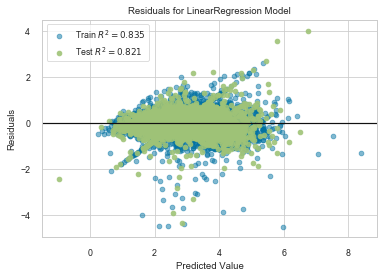

In [180]:
# plot the residucals
visualizer = ResidualsPlot(reg, hist=False)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof() 

### Ridge Regression

In [181]:
# generate Ridge regression model
ridge = Ridge(alpha=1.0, random_state=22).fit(X_train, y_train)
ridge.score(X_test,y_test)

0.8210522888816205

In [182]:
adj_r2 = 1-(1-ridge.score(X_test, y_test))*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)
adj_r2

0.8146960748379659

In [183]:
# calculate mean squared error
mean_squared_error(y_test, ridge.predict(X_test))

0.11835700853004288

### Bayesian Ridge Regression

In [184]:
# generate Bayesian Ridge model
bay = BayesianRidge(alpha_1=0.1, lambda_1=0.1, compute_score=True).fit(X_train, y_train)
print('R2:', bay.score(X_test, y_test))
print('MSE:', mean_squared_error(y_test, bay.predict(X_test)))

R2: 0.8216533720000321
MSE: 0.11795944882207861


In [185]:
adj_r2 = 1-(1-bay.score(X_test, y_test))*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)
adj_r2

0.8153185083996705

While Ridge regression does appear to be a little more accurate than ordinary least squares regression, and Bayes Ridge regression even better still, let's first look at some other models before digging deeper into hyperparameter tuning.

## Gradient Boosting

Best: 0.840642 using {'n_estimators': 1100}
0.837667 (0.013967) with: {'n_estimators': 500}
0.838867 (0.014167) with: {'n_estimators': 600}
0.839551 (0.014367) with: {'n_estimators': 700}
0.839760 (0.014787) with: {'n_estimators': 800}
0.840235 (0.014631) with: {'n_estimators': 900}
0.840385 (0.014526) with: {'n_estimators': 1000}
0.840642 (0.014515) with: {'n_estimators': 1100}
0.840522 (0.014511) with: {'n_estimators': 1200}
0.840412 (0.014485) with: {'n_estimators': 1300}
0.840416 (0.014380) with: {'n_estimators': 1400}


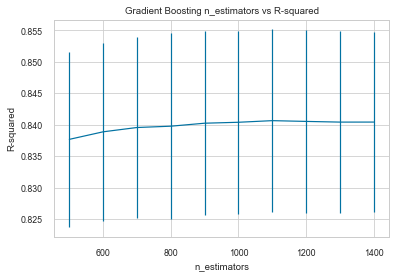

In [223]:
# grid search size of decision tree
model = ensemble.GradientBoostingRegressor(random_state=22)
n_estimators = range(500, 1500, 100)
param_grid = dict(n_estimators=n_estimators)
kfold = KFold(n_splits=5, random_state=22)
grid_search = GridSearchCV(model, param_grid, scoring="r2", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# plot
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("Gradient Boosting n_estimators vs R-squared")
plt.xlabel('n_estimators')
plt.ylabel('R-squared')
plt.savefig('img/gb_n_estimators.png')

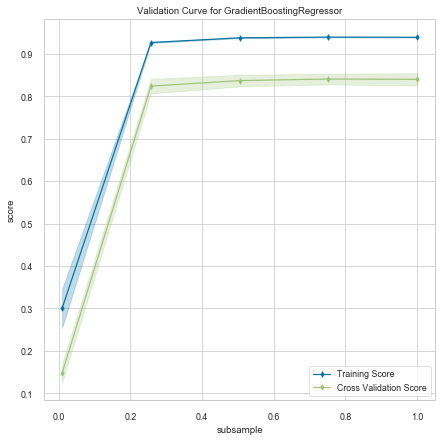

In [226]:
# validation curve using subsample rate
plt.figure(figsize=(7,7))
viz = ValidationCurve(
    ensemble.GradientBoostingRegressor(n_estimators=900, random_state=22), param_name="subsample",
    param_range=np.linspace(0.01,1.0,5), cv=5, scoring="r2"
)

# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof(outpath='img/gb_subsample.png')

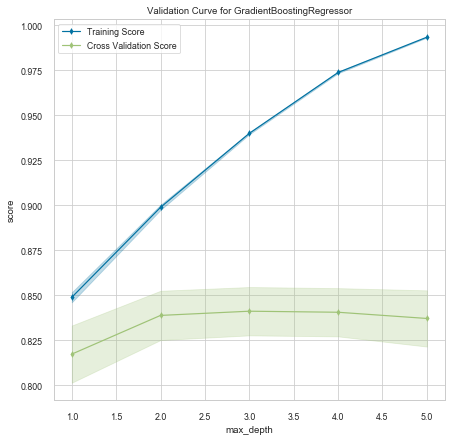

In [234]:
plt.figure(figsize=(7,7))
# Validation Curve using Max Depth
viz = ValidationCurve(
    ensemble.GradientBoostingRegressor(n_estimators=900, subsample=0.8, random_state=22), param_name="max_depth",
    param_range=np.arange(1,6), cv=5, scoring="r2"
)

# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof(outpath='img/GBR_maxdepth.png')

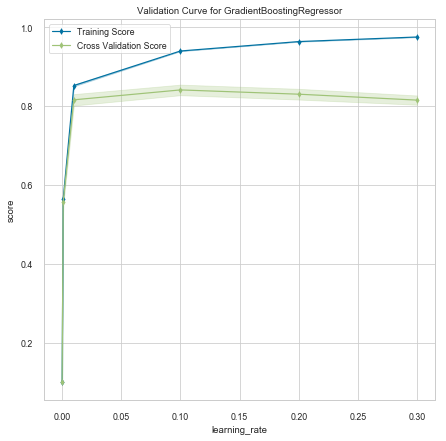

In [235]:
plt.figure(figsize=(7,7))
# Validation Curve using Max Depth
viz = ValidationCurve(
    ensemble.GradientBoostingRegressor(n_estimators=900, subsample=0.8, random_state=22), param_name="learning_rate",
    param_range=[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], cv=5, scoring="r2"
)

# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof(outpath='img/gbr_learning_rate.png')

In [227]:
# Fit regression model
params = {'n_estimators': 900, 'subsample':0.8, 'random_state':22}
gbreg = ensemble.GradientBoostingRegressor(**params).fit(X_train, y_train)

adj_r2 = 1-(1-gbreg.score(X_test, y_test))*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)
print('R2: {0:.4f}\nAdj. R2: {1:.4f}'.format(gbreg.score(X_test, y_test), adj_r2))

# compute mean squared error
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

R2: 0.8449
Adj. R2: 0.8394
MSE: 0.1033


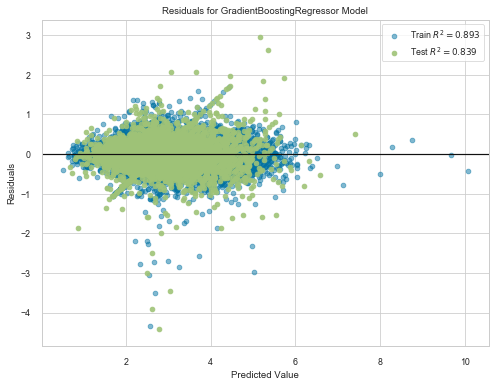

In [232]:
# Instantiate the visualizer
plt.figure(figsize=(8,6))
visualizer = ResidualsPlot(gbreg, hist=False)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof(outpath='img/GBR_residual_plot.png')                 # Draw the data

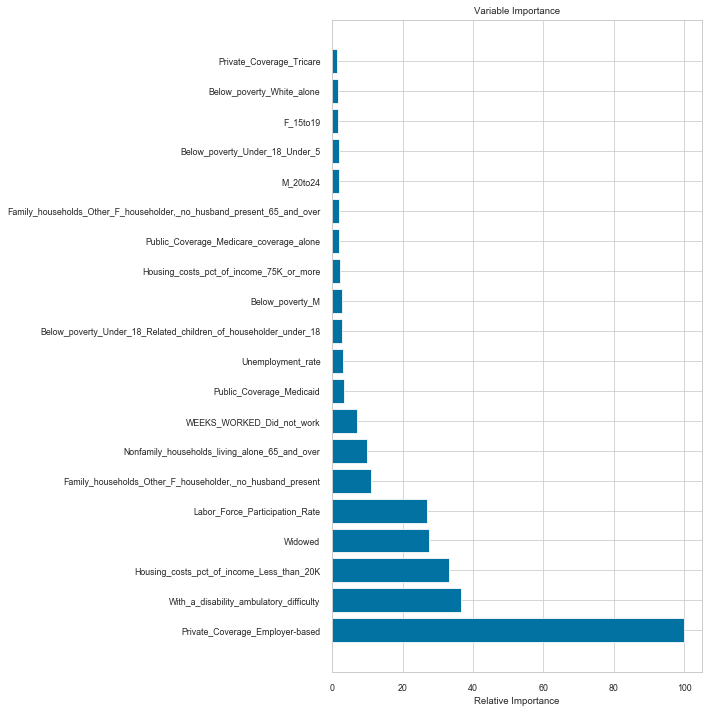

In [233]:
# Plot feature importance
plt.figure(figsize=(10,10))
feature_importance = gbreg.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

# Sort feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [list(X.columns)[i] for i in indices]

# create plot
plt.barh(range(20), feature_importance[indices[:20]], align='center')
plt.yticks(range(20), names)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

plt.tight_layout()
plt.savefig('img/GBR_feature_importance.png')
plt.show()

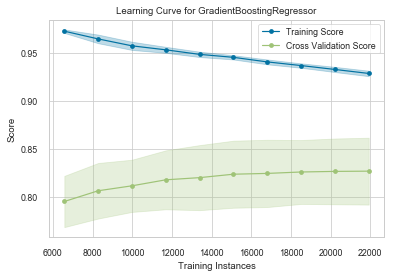

In [239]:
# plot learning curve
cv = KFold(n_splits=5, random_state=22)
sizes = np.linspace(0.3, 1.0, 10)

viz = LearningCurve(
    ensemble.GradientBoostingRegressor(**params), cv=cv, train_sizes=sizes,
    scoring='r2', n_jobs=-1
)

# Fit and poof the visualizer
viz.fit(X, y)
viz.poof(outpath='img/gbr_learning_curve.png')

R2: 0.8439
Adj. R2: 0.8384
MSE: 0.1033


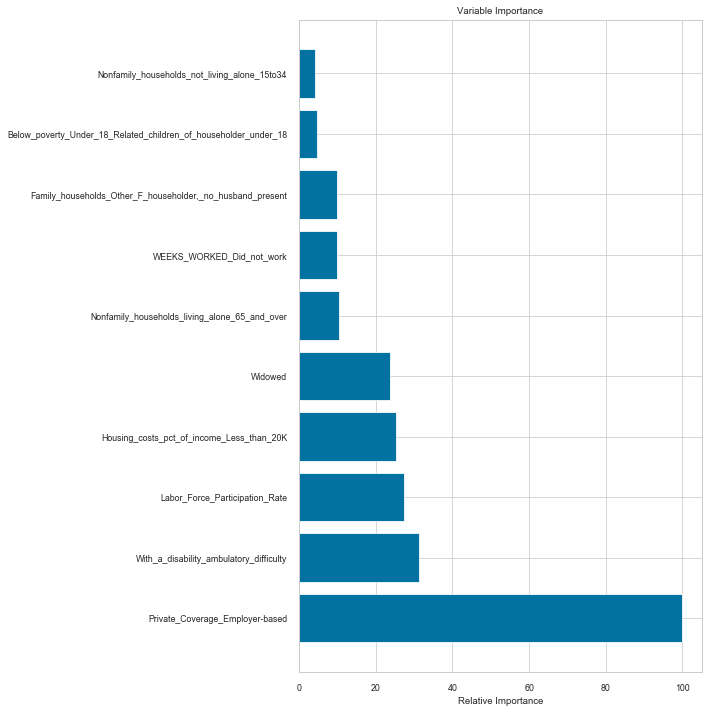

In [244]:
# Fit regression model with a different seed
params = {'n_estimators': 900, 'subsample':0.8, 'random_state':42}
gbreg = ensemble.GradientBoostingRegressor(**params).fit(X_train, y_train)

adj_r2 = 1-(1-gbreg.score(X_test, y_test))*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)
print('R2: {0:.4f}\nAdj. R2: {1:.4f}'.format(gbreg.score(X_test, y_test), adj_r2))

# compute mean squared error
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

# Plot feature importance
plt.figure(figsize=(10,10))
feature_importance = gbreg.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

# Sort feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [list(X.columns)[i] for i in indices]

# create plot
plt.barh(range(10), feature_importance[indices[:10]], align='center')
plt.yticks(range(10), names)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

plt.tight_layout()
plt.show()

### Extreme Gradient Boosting

In [241]:
xgb = XGBRegressor().fit(X_train, y_train)
adj_r2 = 1-(1-xgb.score(X_test, y_test))*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)

print('R2: %.4f' % xgb.score(X_test, y_test))
print('Adjusted R2: %.4f' % adj_r2)
print('MSE: %.4f' % mean_squared_error(y_test, xgb.predict(X_test)))

R2: 0.8162
Adjusted R2: 0.8097
MSE: 0.1216


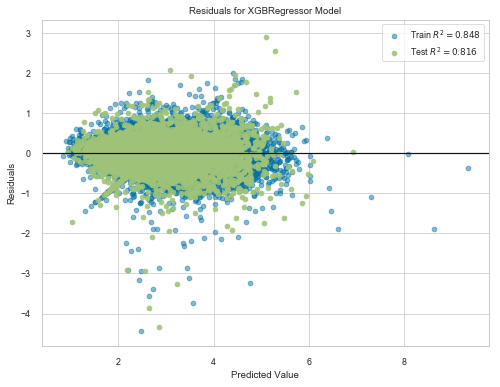

In [192]:
# Instantiate the visualizer
plt.figure(figsize=(8,6))
visualizer = ResidualsPlot(xgb, hist=False)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw the data

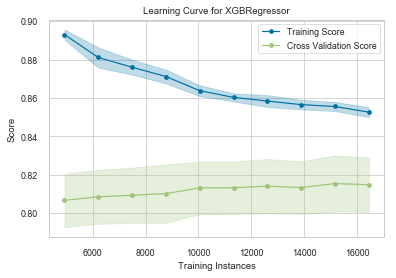

In [194]:
# plot learning curve
cv = KFold(n_splits=5, random_state=22)
sizes = np.linspace(0.3, 1.0, 10)

viz = LearningCurve(
    XGBRegressor(random_state=22), cv=cv, train_sizes=sizes,
    scoring='r2', n_jobs=2
)

# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof(outpath='img/xgb_learning_curve.png')

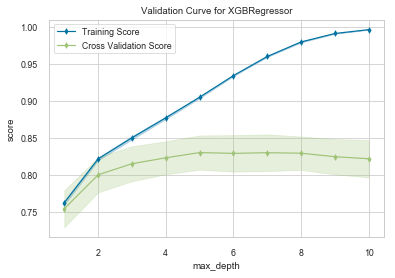

In [195]:
# Validation Curve using Column Sample by Tree
viz = ValidationCurve(
    XGBRegressor(random_state=22), param_name="max_depth",
    param_range=np.arange(1, 11), cv=10, scoring="r2"
)

# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof(outpath='img/valcurve_maxdepth.png')

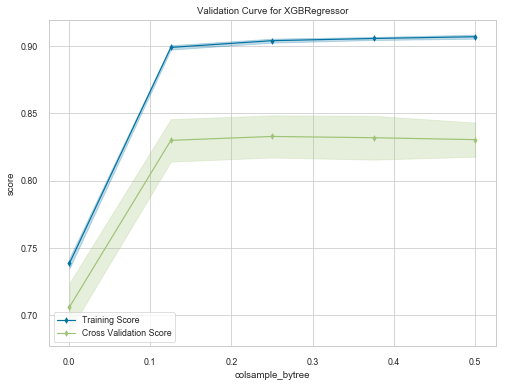

In [196]:
# Validation Curve using Column Sample by Tree
plt.figure(figsize=(8,6))
viz = ValidationCurve(
    XGBRegressor(max_depth=5, random_state=22), param_name="colsample_bytree",
    param_range=np.linspace(0.001, 0.5, 5), cv=5, scoring="r2"
)

# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof(outpath='img/val_cols.png')

Best: 0.839757 using {'n_estimators': 700}
0.839488 (0.013961) with: {'n_estimators': 500}
0.839681 (0.014008) with: {'n_estimators': 600}
0.839757 (0.013833) with: {'n_estimators': 700}
0.839749 (0.014006) with: {'n_estimators': 800}
0.839726 (0.014019) with: {'n_estimators': 900}
0.839683 (0.013882) with: {'n_estimators': 1000}
0.839514 (0.013967) with: {'n_estimators': 1100}
0.839467 (0.013970) with: {'n_estimators': 1200}
0.839377 (0.013957) with: {'n_estimators': 1300}
0.839337 (0.013866) with: {'n_estimators': 1400}


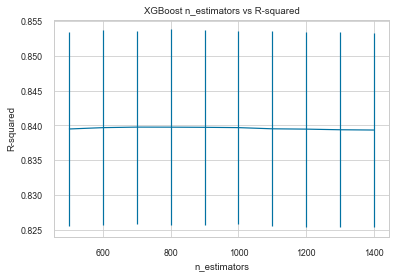

In [198]:
# grid search size of decision tree
model = XGBRegressor(max_depth=5, colsample_bytree=0.1, random_state=22)
n_estimators = range(500, 1500, 100)
param_grid = dict(n_estimators=n_estimators)
kfold = KFold(n_splits=5, random_state=22)
grid_search = GridSearchCV(model, param_grid, scoring="r2", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("XGBoost n_estimators vs R-squared")
plt.xlabel('n_estimators')
plt.ylabel('R-squared')
plt.savefig('img/n_estimators.png')

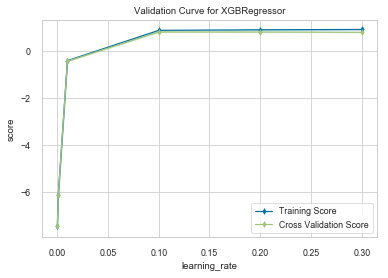

In [200]:
# Validation Curve using Learning Rate
viz = ValidationCurve(
    XGBRegressor(n_extimators=700, max_depth=5, 
                 colsample_bytree=0.1, random_state=22), param_name="learning_rate",
    param_range=[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], cv=5, scoring="r2"
)

# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof(outpath='img/valcurve_learnrate.png')

In [242]:
params = {'n_estimators':700, 'max_depth': 5, 'eta':0.1,
          'colsample_bytree':0.1, 'random_state':22}

xgb = XGBRegressor(**params).fit(X_train, y_train)
print('R2: %.4f' % xgb.score(X_test, y_test))
print('MSE: %.4f' % mean_squared_error(y_test, xgb.predict(X_test)))

adj_r2 = 1-(1-xgb.score(X_test, y_test))*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)
print('Adjusted R2: %.4f' % adj_r2)

R2: 0.8433
MSE: 0.1037
Adjusted R2: 0.8377


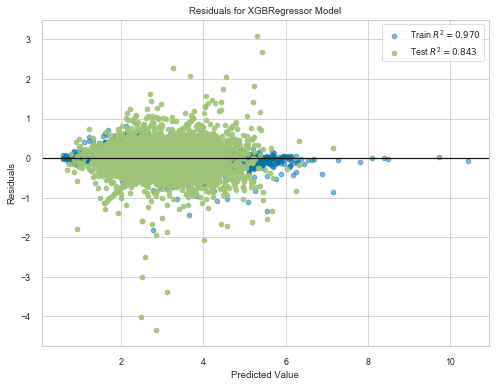

In [243]:
# Instantiate the visualizer
plt.figure(figsize=(8,6))
visualizer = ResidualsPlot(xgb, hist=False)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof(outpath='img/xgb_residuals.png')   #Draw and save figure

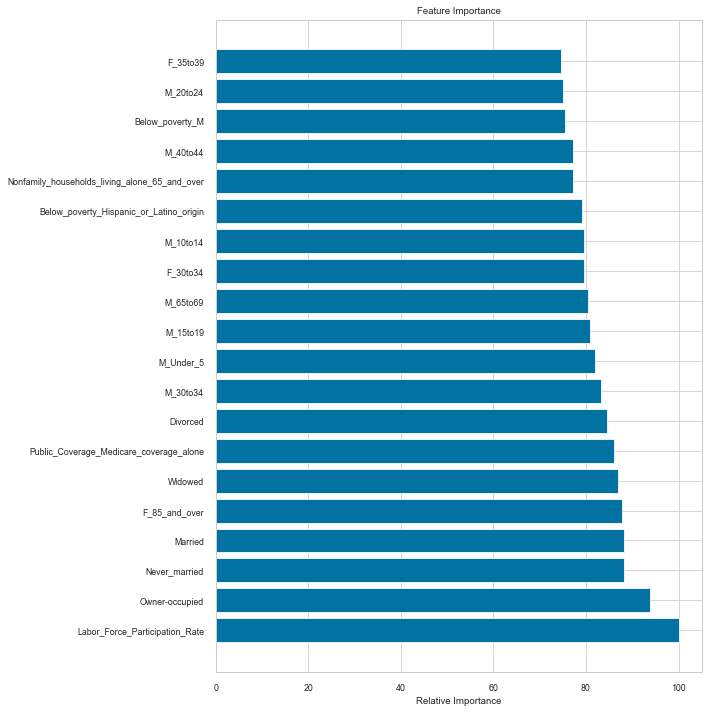

In [176]:
# Plot feature importance
plt.figure(figsize=(10,10))
feature_importance = xgb.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

# Sort feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [list(X.columns)[i] for i in indices]

# create plot
plt.barh(range(20), feature_importance[indices[:20]], align='center')
plt.yticks(range(20), names)
plt.xlabel('Relative Importance')
plt.title('Feature Importance')

plt.tight_layout()
plt.savefig('img/XGBR_feature_importance.png')
plt.show()

## Random Forest Regression

In [70]:
parameters = {'max_depth':[2,50,None], 'n_estimators':[10,50,100]}

rf_regr = ensemble.RandomForestRegressor(random_state=42)
rf_clf = GridSearchCV(rf_regr, parameters, cv=5)
rf_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 50, None], 'n_estimators': [10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [71]:
rf_clf.best_params_

{'max_depth': 50, 'n_estimators': 100}

In [73]:
parameters = {'n_estimators':[200, 350, 500]}

rf_regr = ensemble.RandomForestRegressor(max_depth=50, random_state=42)
rf_clf = GridSearchCV(rf_regr, parameters, cv=5)
rf_clf.fit(X_train, y_train)
rf_clf.best_params_

{'n_estimators': 500}

In [18]:
rf_regr = ensemble.RandomForestRegressor(max_depth=50, n_estimators=500, random_state=22).fit(X_train,y_train)
r_sqr = rf_regr.score(X_test, y_test)
mse = mean_squared_error(y_test, rf_regr.predict(X_test))
print('R-squared: {0:.4f}\nMSE: {1:.4f}'.format(r_sqr,mse))

R-squared: 0.8159
MSE: 0.1217


In [111]:
adj_r2 = 1-(1-r_sqr)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)
adj_r2

0.8093300914284457

## AdaBoost Regression

In [92]:
ada = ensemble.AdaBoostRegressor(random_state=22)
ada.fit(X_train, y_train)
ada.score(X_test, y_test)

0.6132194804409643

In [112]:
# adjusted R-squared
adj_r2 = 1-(1-ada.score(X_test, y_test))*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)
adj_r2

0.5993599426218698

In [93]:
print('MSE: %.4f' % mean_squared_error(y_test, ada.predict(X_test)))

MSE: 0.2558


In [247]:
X.shape

(27408, 235)